# Asset centrality and sector rotation strategy

In [32]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

## Importing the price and P/B data and formatting it

In [21]:
price_df = pd.read_csv('C:/Users/polosen/Documents/Jhuku Trading/Getbhavcopy Folder/Indices/Index_data.csv')
price_df = price_df.loc[:,['Ticker','Date','Close']]

In [22]:
price_df.head()

,Ticker,Date,Close
0,NSEAUTO,20151106,8144.45
1,BANKNIFTY,20151106,17086.50
2,NSEENERGY,20151106,8168.45
3,NSEFINANCE,20151106,7027.65
4,NSEFMCG,20151106,20251.00


In [23]:
Dates = price_df['Date']  #Save dates for future use

# Resetting the index to dates
price_df.set_index('Date', inplace=True)
price_df.head()

,Ticker,Close
Date,,
20151106,NSEAUTO,8144.45
20151106,BANKNIFTY,17086.50
20151106,NSEENERGY,8168.45
20151106,NSEFINANCE,7027.65
20151106,NSEFMCG,20251.00


In [25]:
## Spreading the data in matrix shape
df = price_df.pivot_table(index = ['Date'], columns='Ticker', values='Close', fill_value=0)

In [26]:
df.head()

Ticker,BANKNIFTY,NSEAUTO,NSEENERGY,NSEFINANCE,NSEFMCG,NSEINFRA,NSEIT,NSEMEDIA,NSEMETAL,NSEPHARMA
Date,,,,,,,,,,
20151106,17086.50,8144.45,8168.45,7027.65,20251.00,2775.85,11485.45,2336.90,1720.25,12226.65
20151109,17003.00,8246.20,8175.25,6967.90,20496.15,2740.60,11412.15,2315.30,1723.65,11989.05
20151110,16836.00,8257.70,7885.60,6896.55,20215.80,2689.95,11214.20,2295.85,1681.45,11618.30
20151111,16956.00,8303.95,7943.70,6945.45,20212.55,2715.05,11249.70,2339.60,1699.15,11752.90
20151113,16932.85,8178.30,7932.60,6941.65,19896.20,2687.35,11102.45,2274.00,1704.05,11640.55


In [ ]:
## Repeat same exercise for P/B data
#PB_df.set_index('Date', inplace=True)

In [27]:
## Calculating daily returns from price data
daily_ret = pd.DataFrame(df).pct_change(1).dropna()
daily_ret.head()

Ticker,BANKNIFTY,NSEAUTO,NSEENERGY,NSEFINANCE,NSEFMCG,NSEINFRA,NSEIT,NSEMEDIA,NSEMETAL,NSEPHARMA
Date,,,,,,,,,,
20151109,-0.004887,0.012493,0.000832,-0.008502,0.012106,-0.012699,-0.006382,-0.009243,0.001976,-0.019433
20151110,-0.009822,0.001395,-0.035430,-0.010240,-0.013678,-0.018481,-0.017346,-0.008401,-0.024483,-0.030924
20151111,0.007128,0.005601,0.007368,0.007091,-0.000161,0.009331,0.003166,0.019056,0.010527,0.011585
20151113,-0.001365,-0.015131,-0.001397,-0.000547,-0.015651,-0.010202,-0.013089,-0.028039,0.002884,-0.009559
20151116,0.014885,0.001473,0.001387,0.008514,0.004541,0.010270,-0.008885,0.004683,0.009712,0.006052


## Asset Centrality
## 1. estimate Covariance matrix for each sector using 1Y lookback period (rolling)

In [28]:
Omega = (pd.DataFrame(daily_ret)
        .rolling(252)
        .cov()
        .dropna())

dates = Omega.index.get_level_values(0)

cov_matrix = dict(zip(dates, [Omega.loc[date].values for date in dates]))

## 2. Use PCA on returns matrix for each time period (rolling)

In [37]:
nrows, ncols = daily_ret.dropna().shape   # finding number of rows and columns
window = 22  # setting the rolling window

ncomp = 3 #setting number of PCA components

ret_window = np.empty((252,11), dtype = float)  #intializing return matrix for rolling window

results = []

for i in range(len(daily_ret) - window + 1):
    
    pca = PCA(n_components = ncomp)
    ret_window = daily_ret.iloc[i:(i+window)]
    pca.fit(ret_window)
    
    # Dump components relations with features
    pcacomp = pd.DataFrame(pca.components_, columns = daily_ret.columns, index = ['PC1', 'PC2', 'PC3'])
    
    # Calculate the Absorption ratio for each Eigen vector
    AR = (pca.explained_variance_)/np.sum(pca.explained_variance_)
    
    np.cumsum(np.round(pca.explained_variance_, decimals =4)*100)
    
    pcacomp_T = pcacomp.T
    
    pcacomp_abs = pcacomp_T.abs()
 
    # Calculating the variance from each sector as % of total variance explained by Eigen vector
    weights = (pcacomp_abs/np.sum(pcacomp_abs)).T
    
    weights_array = weights.values  #Converting dataframe to Numpy array
    
    # Calculate Centrality score for for each sector
    
    CS = np.matmul(weights_array.T, AR)
    
    
    results.append(CS)


In [38]:
## Adding dates as an index to the Centrality score matrix

select_date = Dates.iloc[window:len(daily_ret)+1]
cs_df = pd.DataFrame(results, columns = daily_ret.columns, index = select_date)

## 3. Normalize Centrality Scores 

In [39]:
window2 = 252

#calculate rolling means and standard deviation

roller1 = cs_df.rolling(window2)
mean_list = roller1.mean().dropna()
vol_list = roller1.std(ddof=0).dropna()

subser = cs_df[(window2-1):]

cs_norm = (subser - mean_list)/vol_list

## Finding out the Relative Valuation of each sector
## 1. Divide each sector's P/B by average

In [ ]:
window3 = window + window2  #Set rolling window to match that of Centrality scores window

# calculate each sector's average over rolling period "window3"
roller2 = PB_df.rolling(window3)
PB_list = roller2.mean().dropna()
PB_subser = PB_df[(window3-1):]
PB_norm = PB_subser/PB_list

## 2. Dividing normalized P/B values for each sector by avg. across other sectors

In [ ]:
HC_norm = (PB_norm.iloc[:,0] - PB_norm.iloc[:,-0]).mean()
Fin_norm = (PB_norm.iloc[:,1] - PB_norm.iloc[:,-1]).mean()
.......



#Concatenating the series together

RV_norm = pd.concat([HC_norm, Fin_norm, ....])

## Charting heatmap of CS and RV scores

AttributeError: module 'seaborn' has no attribute 'plt'

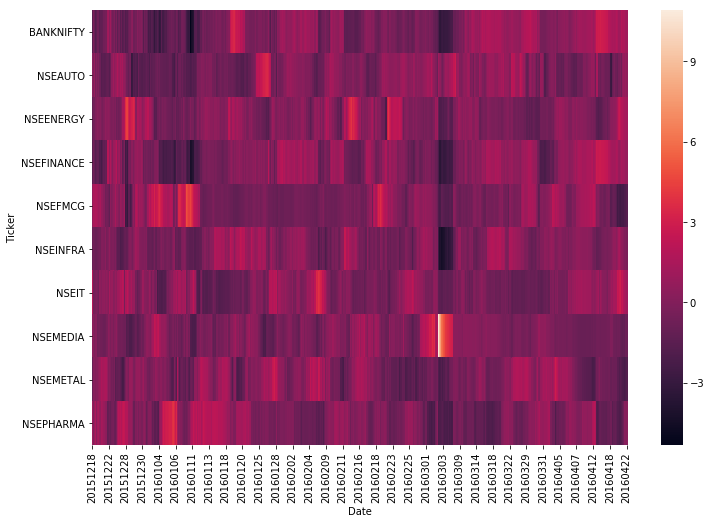

In [40]:
plt.figure(figsize=(12,8))
sns.heatmap(cs_norm.T, xticklabels=25)
sns.plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(RV_norm.T, xticklabels=25)
sns.plt.show()